# Microjax: Jax in 100 Lines of Code

## Introduction

Okay, the goal was 100 lines. In practice it's a bit more.

We'll start with a preview of what we'll be building, review the theory that we'll need to understand the implementation, work through how it works, and finally we'll finish by building a neural network.

This is inspired by Andrej Karpathy's [Micrograd](https://github.com/karpathy/micrograd/tree/master), a PyTorch-like library in about 150 lines of code. Despite PyTorch's popularity, I prefer the way Jax works. I think of PyTorch as having a more *object-oriented* feel, while Micrograd has a more *functional* feel. I think you'll start to see right away in the preview why that is.

This tutorial borrows heavily from Matthew J Johnson's great 2017 presentation on the predecessor to Jax, [autograd](https://github.com/hips/autograd): [Video](https://videolectures.net/videos/deeplearning2017_johnson_automatic_differentiation) / [Slides](https://www.cs.toronto.edu/~duvenaud/talks/Johnson-Automatic-Differentiation.pdf) / [Code](https://github.com/mattjj/autodidact). My main contribution is simplifying a bit and packaging it as a notebook.

## Preview

In [1]:
from microjax import np, grad, jacobian

First, a quick preview of what we're building. We've just imported the entire API of Microjax:
* `np` is just a minimal wrapper around `numpy`. It has all the usual functions: `add`, `sub`, `sinh`, `cosh`, etc (`sin` and `cos` are also easy to implement but I'm trying to keep things minimal).
* `grad` takes the gradient of a function
* `jacobian` is a generalization of `grad`. I'll use `grad` where I can because it's more familiar.

<details>
    <summary>Aside: derivative, gradient, and Jacobian</summary>
    
* The derivative is only defined for univariate functions returning a scalar. $f'(x) = df/dx$
    
* The gradient generalizes the derivative: it's defined for multivariate functions which return a scalar. The gradient of a function taking $n$ arguments is an $n$-vector. $\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x_1}, ..., \frac{\partial f}{\partial x_2} \end{bmatrix}$

* The Jacobian further generalizes the gradient and is defined for multivariate functions returning a vector. The Jacobian of a function from $n$ variables to an $m$-vector is an $m$ by $n$ matrix:

$$
f : \mathbb{R}^n \to \mathbb{R}^m
$$

$$
f(x) =
\begin{bmatrix}
f_1(x) \\
\vdots \\
f_m(x)
\end{bmatrix}
$$

$$
J =
\begin{bmatrix}
\frac{\partial f}{\partial x_1} & \cdots & \frac{\partial f}{\partial x_n}
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n}
\end{bmatrix}
$$
</details>

We'll start by just plotting `tanh` to remind ourselves what it looks like.

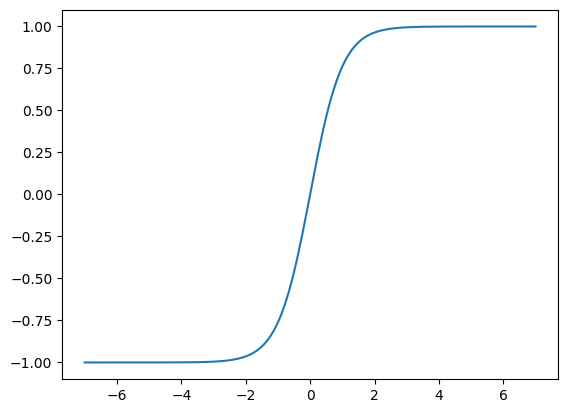

In [2]:
import matplotlib.pyplot as plt
import numpy  # just for linspace

x = numpy.linspace(-7, 7, 200)
_ = plt.plot(x, np.tanh(x))

Now, let's see what Microjax can do:

In [3]:
grad(np.tanh)(0)

np.float64(1.0)

Did you see that? We took the gradient of a function (which is another function), and called that function with 0. In other words, the gradient of tanh at 0 is 1. Let's plot it:

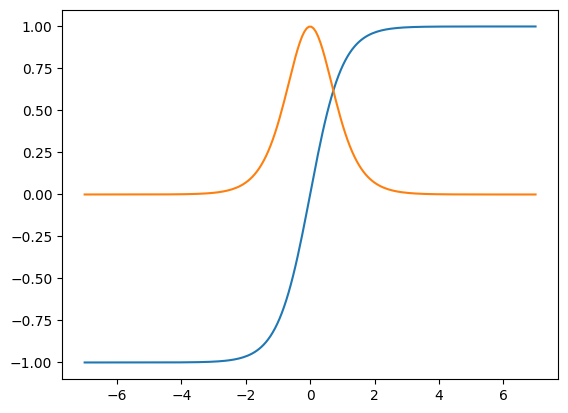

In [4]:
_ = plt.plot(
    x, np.tanh(x),
    x, jacobian(np.tanh)(x),
)

(remember that `jacobian` is just a generalization of `grad`)

<details>
  <summary>Aside: Why didn't we just use <code>grad</code> then?</summary>
<p>Try calling <code>grad(np.tanh)(x)</code> (go ahead and try).</p>
    
<p>You should see "Gradient only defined for scalar-output functions. Output had shape: (200,)". The problem is that <code>x</code> is a 200-array, i.e. it has shape <code>(200,)</code>, and <code>np.tanh</code> is a vectorized function so, given <code>x</code>, it will also return an array with shape <code>(200,)</code>. The gradient function is relatively simple because it only operates on scalar-valued functions, so we need the more general Jacobian here.</p>
</details>

What's more, we can take higher derivatives:

In [5]:
grad(grad(np.tanh))(0)

np.float64(-0.0)

We can do this as many times as we want. Here are the first four derivatives of `tanh` plotted (uncomment the next two or play with other functions).

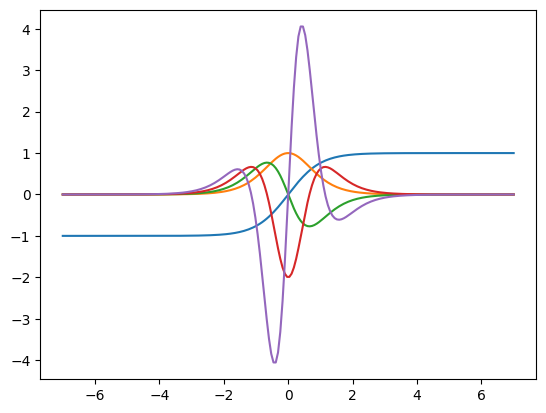

In [6]:
_ = plt.plot(
    x, np.tanh(x),
    x, jacobian(np.tanh)(x),
    x, jacobian(jacobian(np.tanh))(x),
    x, jacobian(jacobian(jacobian(np.tanh)))(x),
    x, jacobian(jacobian(jacobian(jacobian(np.tanh))))(x), 
    # x, jacobian(jacobian(jacobian(jacobian(jacobian(np.tanh)))))(x),
    # x, jacobian(jacobian(jacobian(jacobian(jacobian(jacobian(np.tanh))))))(x),
)

The amazing thing about Microjax is, that was the entire API. Use `microjax.np` as if it was just numpy and `grad` to take the gradient.

<details>
    <summary>Aside: Why <code>microjax.np</code>?</summary>
    
We'll cover this in more detail later, but the short version is that `jax.numpy` has the same API as `numpy`, but supports tracing the computation for backpropagation. `microjax.np` doesn't quite support the full API (because *micro*).
</details>

<details>
    <summary>Aside: The Jacobian and other functions</summary>
    
You rarely need `jacobian` in real code (at least if you're writing neural networks).

Aren't there other functions? Real Jax includes various other functions, e.g. `jacfwd` for a forward-mode evaluated Jacobian, `hessian`, `value_and_grad`. But `np` and `grad` are all you need to build a neural net.
</details>

Now that we've had a preview, let's take a few minutes to review some theory.

## Theory: Jacobians, Chain Rule, Forward- and Reverse-Mode

Assume that we have some function $F : \mathbb{R}^{n} \to \mathbb{R}$. Let's say that $F$ is made up of a chain of functions, which we can individually differentiate: $F = D \circ C \circ B \circ A$, more explicitly:

$$y = F(x) = D(C(B(A(x))))$$

$$
y = D(c), \quad \textbf{c} = C(b), \quad \textbf{b} = B(a), \quad \textbf{a} = A(x)
$$

We'll sometimes use boxes to visualize the shapes of inputs and outputs:

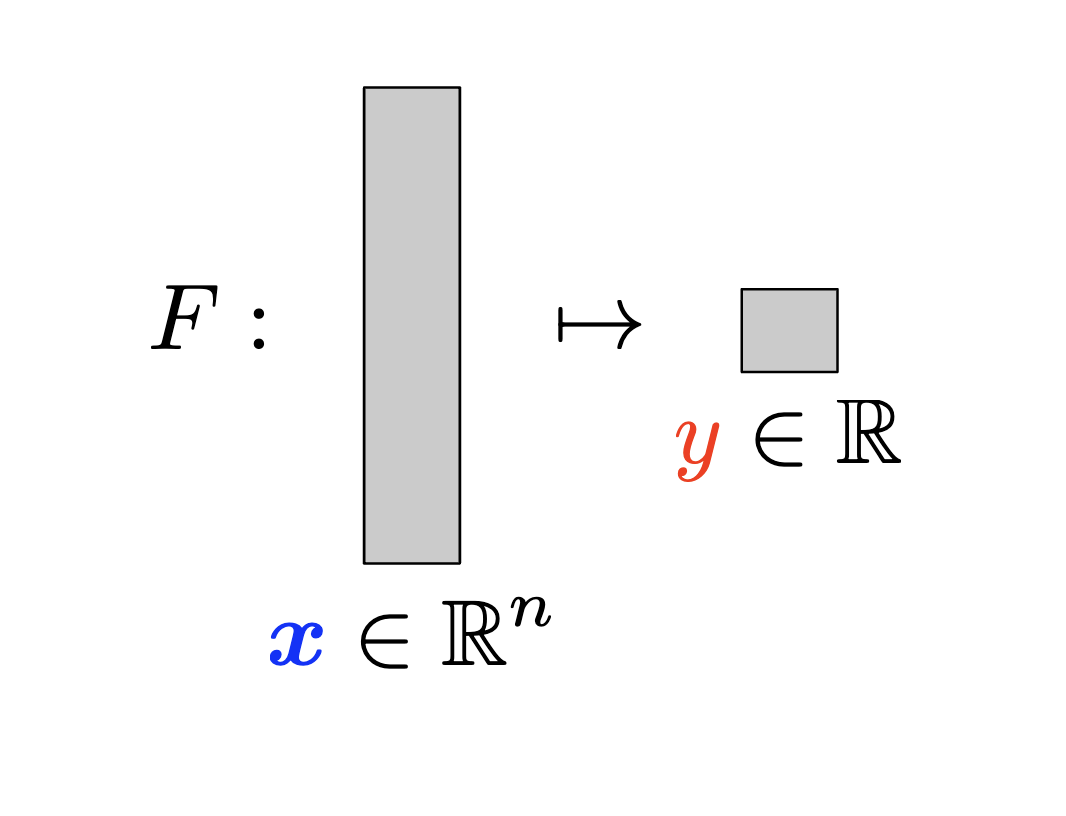

<details>
    <summary>Aside: The Shape of $F$</summary>
For now we're working in the simplified setting where $F$ returns a scalar, but everything still works if $F$ returns a vector.
</details>

Our goal is to evaluate the gradient of $F$.

We write $F'(x)$ for the Jacobian matrix of $F$ evaluated at $x$. This is a matrix of partial derivatives. In this case it's just one row (because $F$ has a scalar output, with a vector input).

$$
F'(x) = \frac{\partial y}{\partial x} =
\begin{bmatrix}
\frac{\partial y}{\partial x_1} & \cdots & \frac{\partial y}{\partial x_n}
\end{bmatrix}
$$

The chain rule tells us that we can write the Jacobian $F'(x)$ as the product of the other Jacobian matrices.

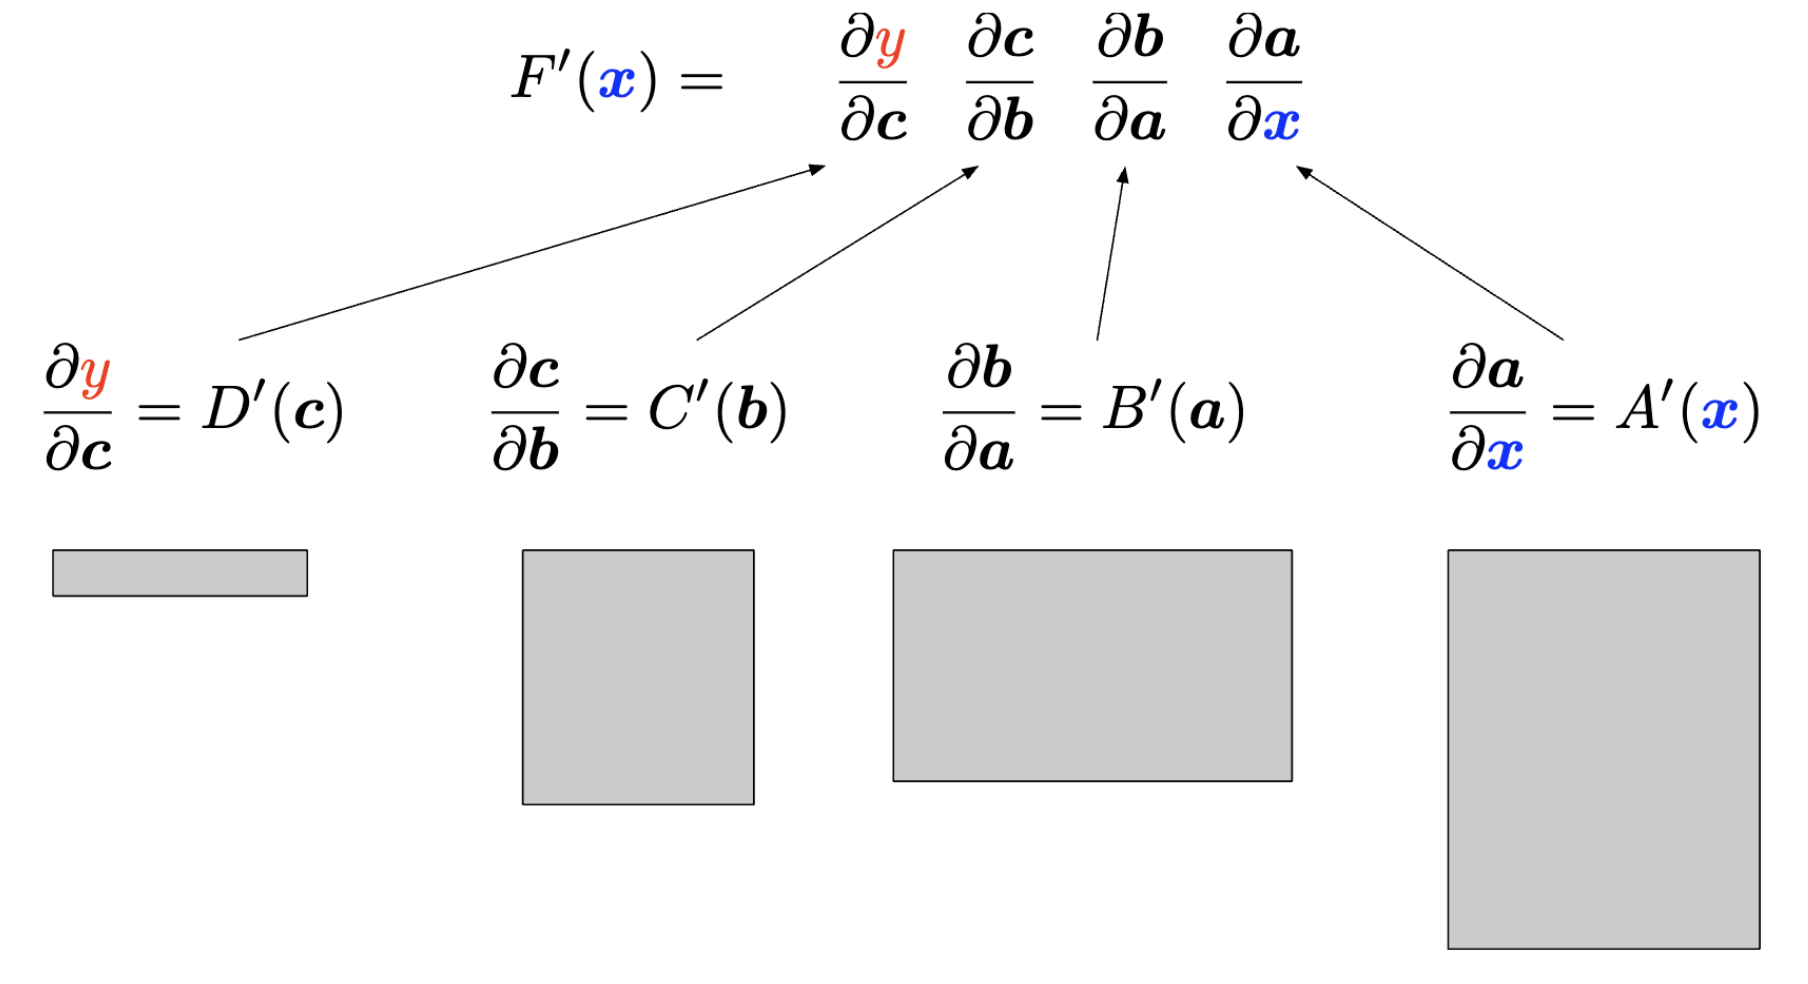

<details>
<summary>Question: What are the sizes of the four boxes (representing the Jacobian matrices $D'(c)$, $C'(b)$, $B'(a)$, and $A'(x)$)?</summary>
    
* The first is 1 by the size of the output of C, or $1 \times \dim C$
* $\dim C \times \dim B$
* $\dim B \times \dim A$
* $\dim A \times n$ (where $n = \dim x$)
</details>

<details>
<summary>Question: Does the order of multiplication matter?</summary>

Yes! Different orders can have very different performance characteristics, both in terms of FLOPs and memory. This is an interesting and [well-studied problem](https://en.wikipedia.org/wiki/Matrix_chain_multiplication).
</details>

In practice, there are two common, simple ways to calculate the Jacobian.

First is forward accumulation, where we start computing from the inputs to the outputs

$$
F'(x) =
\frac{\partial y}{\partial c}
\left( 
\frac{\partial c}{\partial b}
\left( 
\frac{\partial b}{\partial a} \frac{\partial a}{\partial x} 
\right) 
\right)
$$

The big problem with forward accumulation is that if there are $n$ inputs and an $m$-dimensional internal state, then the Jacobian is $m \times n$. Since neural networks are the main use for Jax, you should imagine that that's a *very* big matrix.

$$
\frac{\partial b}{\partial x} =
\begin{bmatrix}
\frac{\partial b_1}{\partial x_1} & \cdots & \frac{\partial b_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial b_m}{\partial x_1} & \cdots & \frac{\partial b_m}{\partial x_n}
\end{bmatrix}
$$

The alternative is reverse accumulation, where we start computing the Jacobian from the opposite end, the output.

$$
F'(x) =
\left( 
\left(
\frac{\partial y}{\partial c} \frac{\partial c}{\partial b}
\right) 
\frac{\partial b}{\partial a} 
\right) 
\frac{\partial a}{\partial x}
$$

This turns out to be really efficient because neural networks (in training) typically have a scalar output, the loss. This means that each intermediate Jacobian is only as big as the internal state, in this case $1 \times m$.

$$
\frac{\partial y}{\partial b} =
\begin{bmatrix}
\frac{\partial y}{\partial b_1} & \cdots & \frac{\partial y}{\partial b_m}
\end{bmatrix}
$$

So, most of the time, reverse accumulation is the right default.

One thing we might want to do is, instead of building the entire Jacobian matrix, make a function which returns it multiplied by some vector.

$$
F'(x) v =
\frac{\partial y}{\partial c}
\frac{\partial c}{\partial b}
\frac{\partial b}{\partial a}
\frac{\partial a}{\partial x}
v
$$

$$
F'(x) v =
\frac{\partial y}{\partial c}
\left(
\frac{\partial c}{\partial b}
\left(
\frac{\partial b}{\partial a}
\left(
\frac{\partial a}{\partial x}
v
\right)
\right)
\right)
$$

Why would you want to do that? As we'll see when we reach the implementation, for our primitives it's typically *much* simpler to represent them as functions than as matrices. As a very simple example, given $f : \mathbb{R}^n \to \mathbb{R}^m$, $f(x) = 2 x$, what's $\frac{\partial{f}}{\partial{x}}$? Just $\vec{2}$ of course. We wouldn't want to represent this as an $n$-dimensional matrix. We'll see something similar with other primitives where the matrix might be diagonal or otherwise quite inefficient to represent as a full matrix.

We'll call these operators *Jacobian-vector products* (JVPs).

What if you actually want the Jacobian, rather than this operator which gives us the JVP? Well, if $v$ is the vector $[1, 0, \ldots]$, i.e. the first standard basis vector, or the first one-hot vector... then $F'(x) v$ is the first column of the Jacobian. So we can call the JVP with each of the standard basis vectors and build the Jacobian one column at a time.

Remember that the Jacobian for a function $f : \mathbb{R}^n \to \mathbb{R}^m$ is in $\mathbb{R}^{m \times n}$. In ML, $n$ is usually in the millions to trillions (the parameter count), while $m$ is usually 1 (the loss), our Jacobian has one row and *many* columns, so it would take forever to build the Jacobian this way.

You can think of this as passing an identity matrix ($\frac{\partial x}{\partial x}$), an $n \times n$ matrix which has as columns each of the standard basis vectors.

$$
F'(x) =
\frac{\partial y}{\partial c}
\left(
\frac{\partial c}{\partial b}
\left(
\frac{\partial b}{\partial a}
\left(
\frac{\partial a}{\partial x}
\frac{\partial x}{\partial x}
\right)
\right)
\right)
$$

Instead of multiplying it on the right (a JVP) we can also multiply the vector on the left (a *Vector-Jacobian Product* or *VJP*).

$$
v^\top F'(x) =
v^\top \frac{\partial y}{\partial c}
\frac{\partial c}{\partial b}
\frac{\partial b}{\partial a}
\frac{\partial a}{\partial x}
$$

$$
v^\top F'(x) =
\left( 
\left( 
\left( 
v^\top \frac{\partial y}{\partial c} 
\right) 
\frac{\partial c}{\partial b} 
\right) 
\frac{\partial b}{\partial a} 
\right) 
\frac{\partial a}{\partial x}
$$

In contrast to JVPs, VJPs calculate the Jacobian one row at a time. Since we're usually working with a single very big row, this is quite efficient (often with cost similar to the cost of calling $F$).

We can think of this as passing an $m \times m$ (usually $1 \times 1$) identity matrix ($\frac{\partial y}{\partial y}$), which has as rows each of the standard basis vectors.

$$
F'(x) =
\left( 
\left( 
\left( 
\frac{\partial y}{\partial y} 
\frac{\partial y}{\partial c} 
\right) 
\frac{\partial c}{\partial b} 
\right) 
\frac{\partial b}{\partial a} 
\right) 
\frac{\partial a}{\partial x}
$$

<details>
<summary>Aside: Non-chain composition</summary>

Of course, not all computation is structured as a simple chain of function calls! We might actually have a DAG, where some functions take multiple arguments (which we'll call fan-in) and some functions return multiple results (fan-out).

Handling fan-in is simple -- we just think of it as stacking the two inputs to get a version of $F$ with just one input. Then we can build separate Jacobians, one for each input.

$$
y = F(x_1, x_2)
$$

$$
\frac{\partial y}{\partial x_1} = F_1'(x_1, x_2)
\quad
\frac{\partial y}{\partial x_2} = F_2'(x_1, x_2)
$$

We can also handle fan-out easily. Think of this G function as duplicating its input $x$.

$$
G(x) =
\begin{bmatrix}
x \\ x
\end{bmatrix}
=
\begin{bmatrix}
I \\ I
\end{bmatrix} x
$$

What's the Jacobian of $G$?

$$
G'(x) =
\begin{bmatrix}
I \\ I
\end{bmatrix}
$$

Well, we're getting partial derivative information from each of our outputs, and the Jacobian is just their sum.

$$
v^\top G'(x) =
\begin{bmatrix}
v_1^\top & v_2^\top
\end{bmatrix}
\begin{bmatrix}
I \\ I
\end{bmatrix}
= v_1^\top + v_2^\top
$$
</details>

## Implementation

Phew! Enough theory, let's get into the code!

There are three pieces we'll put together:

1. Building a computation graph ("tracing")
2. Defining a vector-Jacobian product (VJP) for each primitive
3. Composing VJPs to get a VJP for the whole function

### 1. Building a computation graph

Let's look at an example function we might want to build the computation graph for. Here we'll focus on `neuron`, which uses `relu`.

In [7]:
def relu(x):
    return (x + abs(x)) / 2

def neuron(w, b, x):
    z = w @ x + b
    return relu(z)

Our strategy will be to *trace* the function by passing it *boxed* values instead of arrays.
So, `w`, `b`, and `x` will be instances of `Box` (which we're about to define), rather than
`np.ndarray`. You can of course
still call `neuron` with Numpy arrays, but if `Box` supports `__add__`, `__matmul__`, `__div__`,
and `__abs__`, then we should be able to put boxes in and get a box out. Our function will still
compute a value, but it will also record the shape of the computation graph.

Each time we need to call a primitive, we'll need to first unbox the value, call the primitive,
and box the result on the other end.

The goal is to build a graph of `Node`s mirroring the computation which actually took place.
One will be created when (and *only* when) calling a primitive.

In [8]:
from dataclasses import dataclass
from typing import Callable, Any

class Box:
    def __init__(self, value, trace_id, node):
        self._value = value
        self._node = node
        self._trace_id = trace_id

    def __add__(self, other):
        return np.add(self, other)

    def __sub__(self, other):
        return np.subtract(self, other)
        
    # ... __div__, __abs__, etc

@dataclass(frozen=True)
class Node[T]:
    """A node in a computation graph.

    parents and argnums should be the same length. There is one for each boxed argument.
    args could be longer if there are non-Box arguments.
    """

    parents: tuple["Node[T]"]  # For each boxed argument, the node that produced it.
    value: T  # The output of the primitive function.
    fun: Callable[..., T]  # Wrapped primitive function
    args: tuple[Any]  # All (unboxed) positional arguments
    kwargs: dict[str, Any]  # Additional keyword arguments
    argnums: tuple[int]  # Positional indices of boxed values

    @staticmethod
    def new_root():
        return Node((), None, lambda x: x, (), {}, ())

    # We have to override hash because dicts aren't hashable.
    def __hash__(self):
        return id(self)

This diagram shows what happens when we call `np.sum`.
It shows both the nodes in the graph that ends up being built
as well as the boxing and unboxing that we do around the primitive.

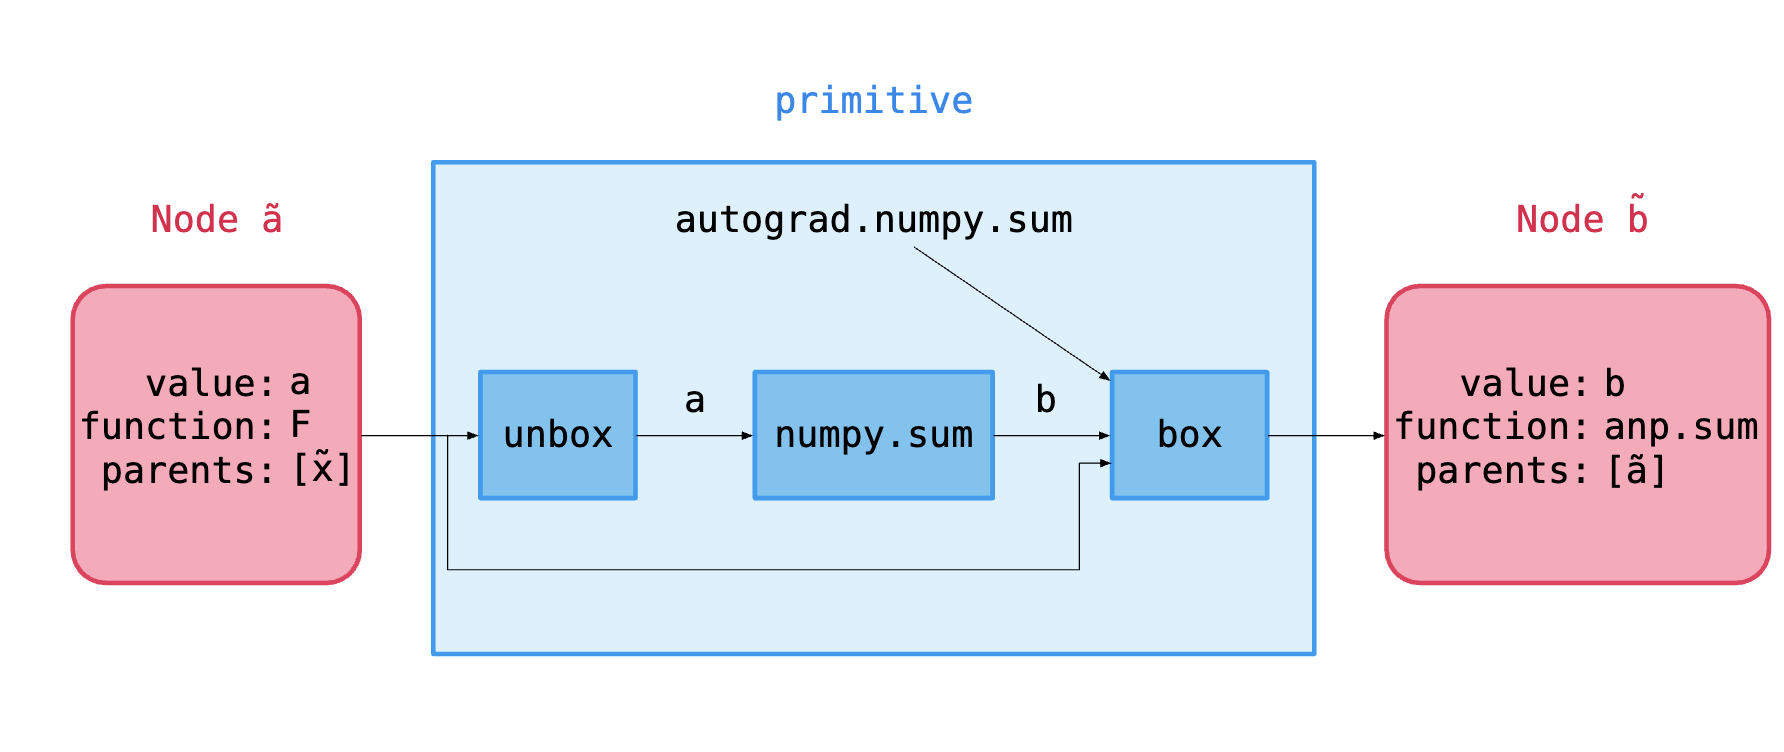

We also define a primitive function which does the boxing / unboxing and creates one `Node` in the graph.

In [9]:
def primitive(f_raw):
    def f_wrapped(*args, **kwargs):
        argvals, argnums, parents = list(args), [], []
        for i, arg in enumerate(args):
            if isinstance(arg, Box):
                argvals[i] = arg._value
                argnums.append(i)
                parents.append(arg._node)
        raw_result = f_raw(*argvals, **kwargs)
        if len(parents) == 0:
            return raw_result
        node = Node(parents, raw_result, f_wrapped, argvals, kwargs, argnums)
        return Box(raw_result, trace_id, node)

    return f_wrapped

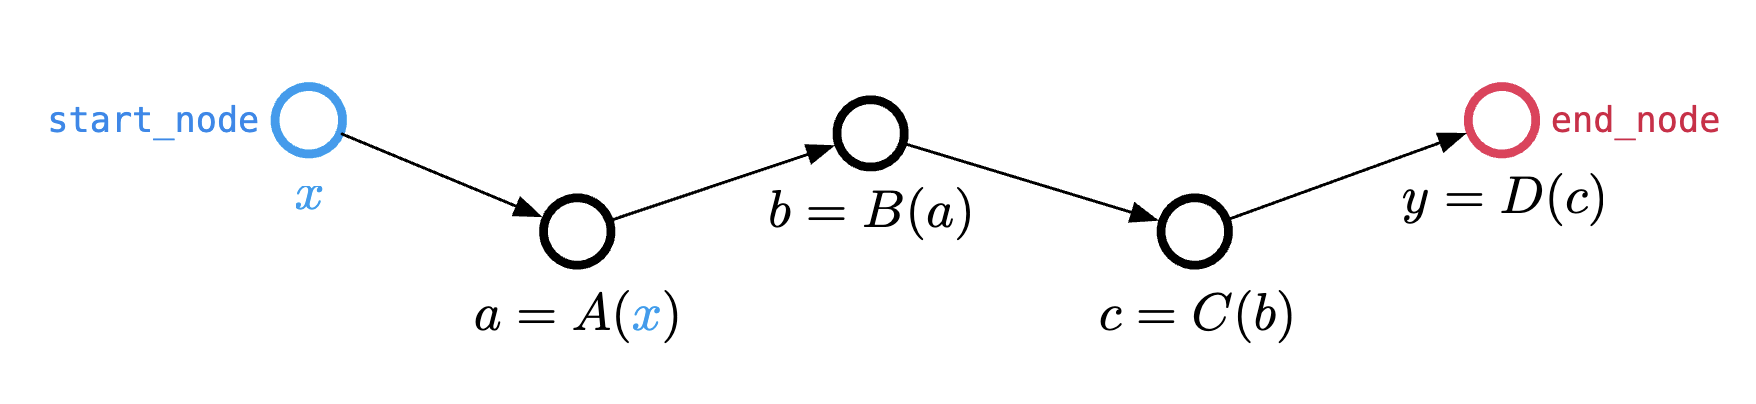

Earlier, in the theory section, we mentioned that functions didn't have to be a chain of primitives, they can also have fan-in and fan-out. The code we're writing now will actually work for any directed acyclic graph (DAG).

One important thing to note about the graph of `Node`s we've built: it doesn't contain any control flow! Any structure is recorded statically how it executed.

Quiz:

What does the graph for this function look like?

```python
def f(x):
    import random
    return np.cosh(x) if random.random() > 0.5 else np.sinh(x)
```

What about this function?

```python
def g(x):
    for _ in range(5):
        x = x + 1
    return x
```

Expand the outputs of the next two cells to check your answer

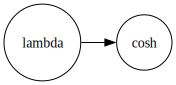

In [10]:
from graphing import trace_and_draw

def f(x):
    import random
    return np.cosh(x) if random.random() > 0.5 else np.sinh(x)

trace_and_draw(f, np.array([0.5]))

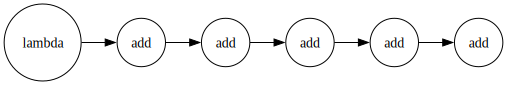

In [11]:
def g(x):
    for _ in range(5):
        x = x + 1
    return x

trace_and_draw(g, np.array([0.5]))

There's one more function we need to finish tracing: `trace` itself.

All we need to do is create a `Box` to pass into the computation, then unbox it at the end.

In [12]:
def trace(start_node, fun, x):
    """(forward pass / build computation graph)"""
    start_box = Box(x, trace_id, start_node)
    end_box = fun(start_box)

    if isinstance(end_box, Box):
        return end_box._value, end_box._node
    else:
        # Output seems independent of input
        return end_box, None

In [8]:
"""Advanced: the real definition of primitive and trace.

What was the problem with the functions we just defined?
They work perfectly fine if we only ever take a single grad:
calling grad(np.tanh) will work.

The problem arises when we take multiple gradients:
e.g. grad(grad(np.tanh)). Here the outer `grad` is passsed
a function returned by the inner `grad(np.tanh)`.
This is a vjp (which we'll define below).
This means we're going to trace, that is, pass `Box`es through a VJP which we've defined.
We need to mark out boxes so that we end up building a compuation graph only
of nodes from the same call to `trace`.
"""

def find_top_boxed_args(args):
    """Finds boxed arguments with largest trace_id.

    Equivalent to finding the largest trace_id of any argument, keeping args
    with the same, and dropping the remainder.

    Args:
      args: Arguments to function wrapped by primitive().

    Returns:
      top_boxes: List of (index, boxed argument). Arguments have same, largest
        trace_id.
      top_trace_id: trace_id of all elements in top_boxes.
    """
    top_trace_id = -1
    top_boxes = []
    for argnum, arg in enumerate(args):
        if isinstance(arg, Box):
            if arg._trace_id > top_trace_id:
                top_boxes = [(argnum, arg)]
                top_trace_id = arg._trace_id
            elif arg._trace_id == top_trace_id:
                top_boxes.append((argnum, arg))
    return top_boxes, top_trace_id

def primitive(f_raw):
    def f_wrapped(*args, **kwargs):
        # Fetch boxed arguments with largest trace_id.  This ensures that the
        # computational graph being constructed only consists of other nodes
        # from the same call to trace().
        boxed_args, trace_id = find_top_boxed_args(args)
        if boxed_args:
            # Replace some elements of args with corresponding unboxed values.
            argvals = list(args)
            for argnum, box in boxed_args:
                argvals[argnum] = box._value
            # Get nodes for each boxed argument.
            parents = tuple(box._node for _, box in boxed_args)

            # Get argument indices for each boxed argument.
            argnums = tuple(argnum for argnum, _ in boxed_args)

            # Calculate result of applying original numpy function.
            #
            # Note that we use a recursive call here in order to also augment
            # outer calls to trace() with lower trace_ids.
            ans = f_wrapped(*argvals, **kwargs)

            node = Node(parents, ans, f_wrapped, argvals, kwargs, argnums)
            return Box(ans, trace_id, node)
        else:
            return f_raw(*args, **kwargs)

    return f_wrapped

trace_id = 0

def trace(start_node, fun, x):
    """(forward pass / build computation graph)"""
    global trace_id
    trace_id += 1
    try:
        start_box = Box(x, trace_id, start_node)
        end_box = fun(start_box)

        if isinstance(end_box, Box) and end_box._trace_id == start_box._trace_id:
            return end_box._value, end_box._node
        else:
            # Output seems independent of input
            return end_box, None
    finally:
        trace_id -= 1

Finally, we define `np` as a class, where we simply wrap each primitive.

<details>
    <summary>Why not a module?</summary>

Just so I could include the definition of `np` in this notebook.
</details>

In [13]:
class Np:
    def __init__(self):
        self.negative = primitive(np.negative)
        self.exp = primitive(np.exp)
        self.log = primitive(np.log)
        self.multiply = primitive(np.multiply)
        self.add = primitive(np.add)

np = Np()

### 2. VJPs

Now the setting is that we have some computation $a = A(x)$, with final loss $y$. Now, we get the derivative with respect to $a$: $\frac{\partial y}{\partial{a}}$. We need to apply our vector-Jacobian product operator ($A'( x ) = \frac{\partial{a}}{\partial{x}}$) to pull that derivative back to get $\frac{\partial y}{\partial x}$.

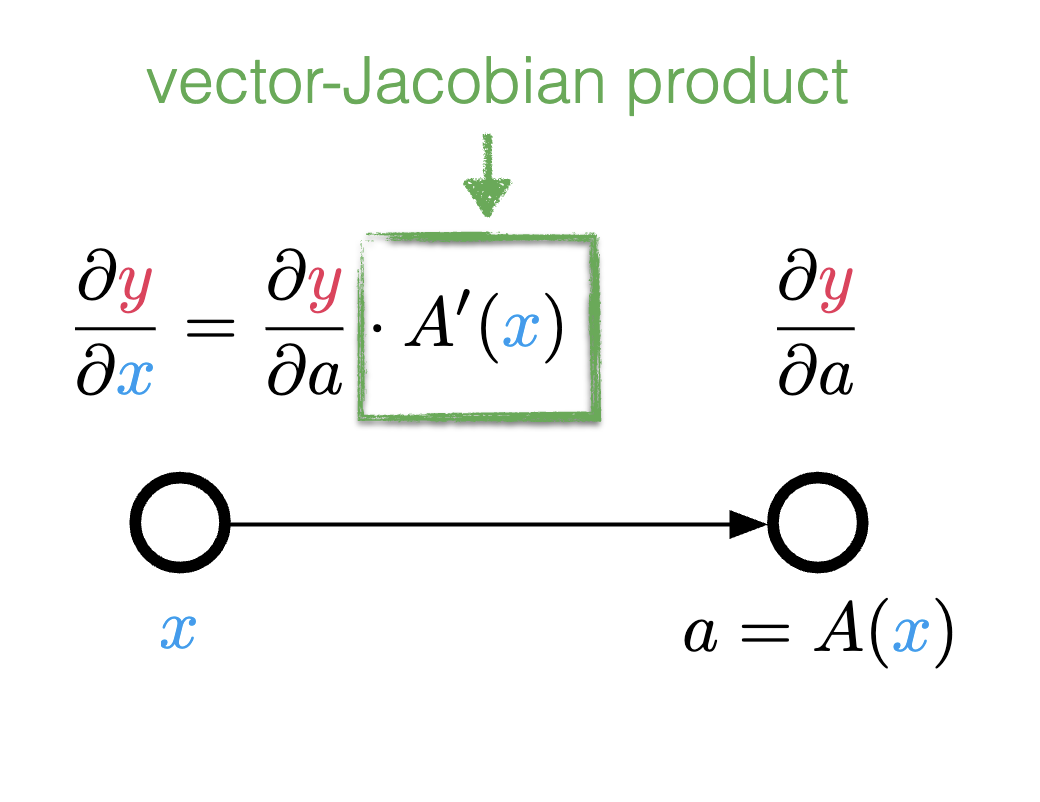

In [14]:
"""
Here are some example VJPs. Note that we're defining a different VJP for each argument.
* g is the gradient we want to pull back
* ans is the output from the function
* x is the input
"""

primitive_vjps = {
    np.negative: {0: lambda g, ans, x: -g},
    np.add: {
        0: lambda g, ans, x, y: g,
        1: lambda g, ans, x, y: g,
    },
    np.multiply: {
        0: lambda g, ans, x, y: y * g,
        1: lambda g, ans, x, y: x * g,
    },
    np.exp: {0: lambda g, ans, x: ans * g},
    np.log: {0: lambda g, ans, x: g / x},
}

### 3. Composing VJPs Backward

Now that we've defined our primitive VJPs, we can start with $\frac{\partial{y}}{\partial{y}} = 1$, and keep pulling back the derivatives until we reach the start node.

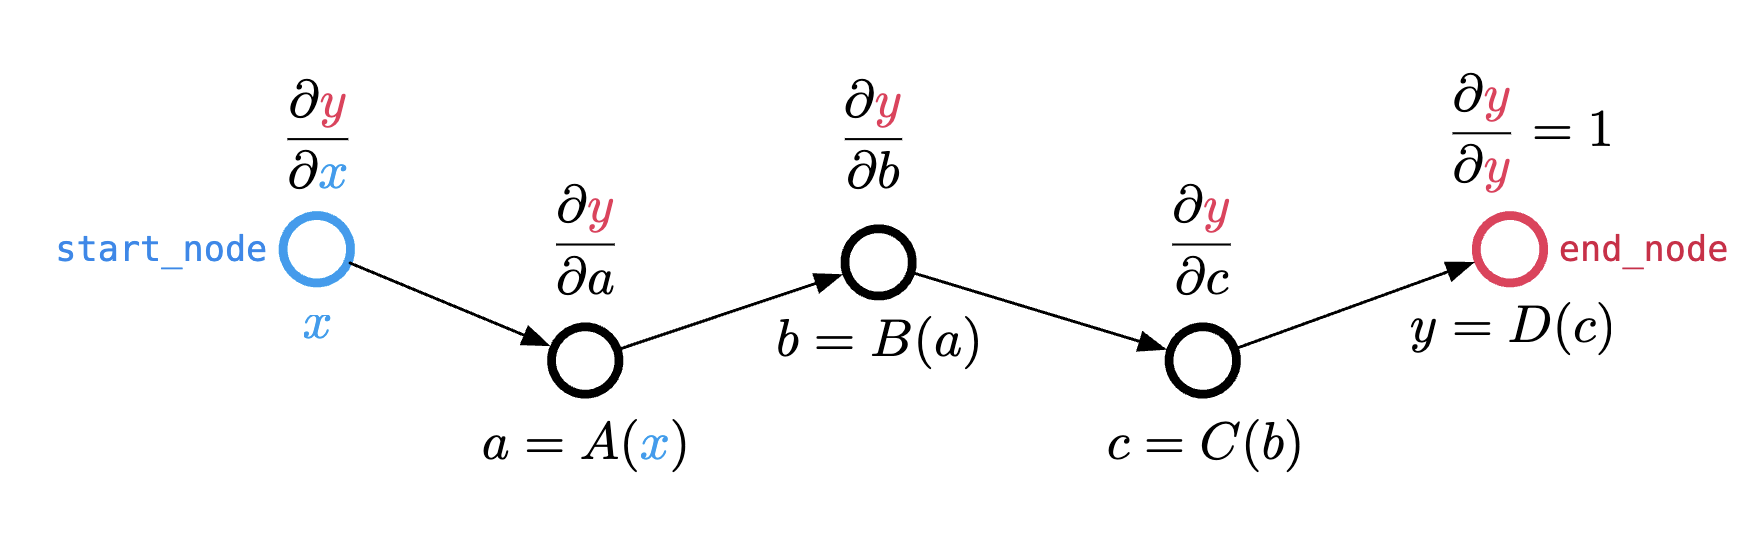

<details>
    <summary>Aside: higer-order autodiff</summary>

The backward pass is itself traceable! This is how higher-order autodiff (`grad(grad)`) works.

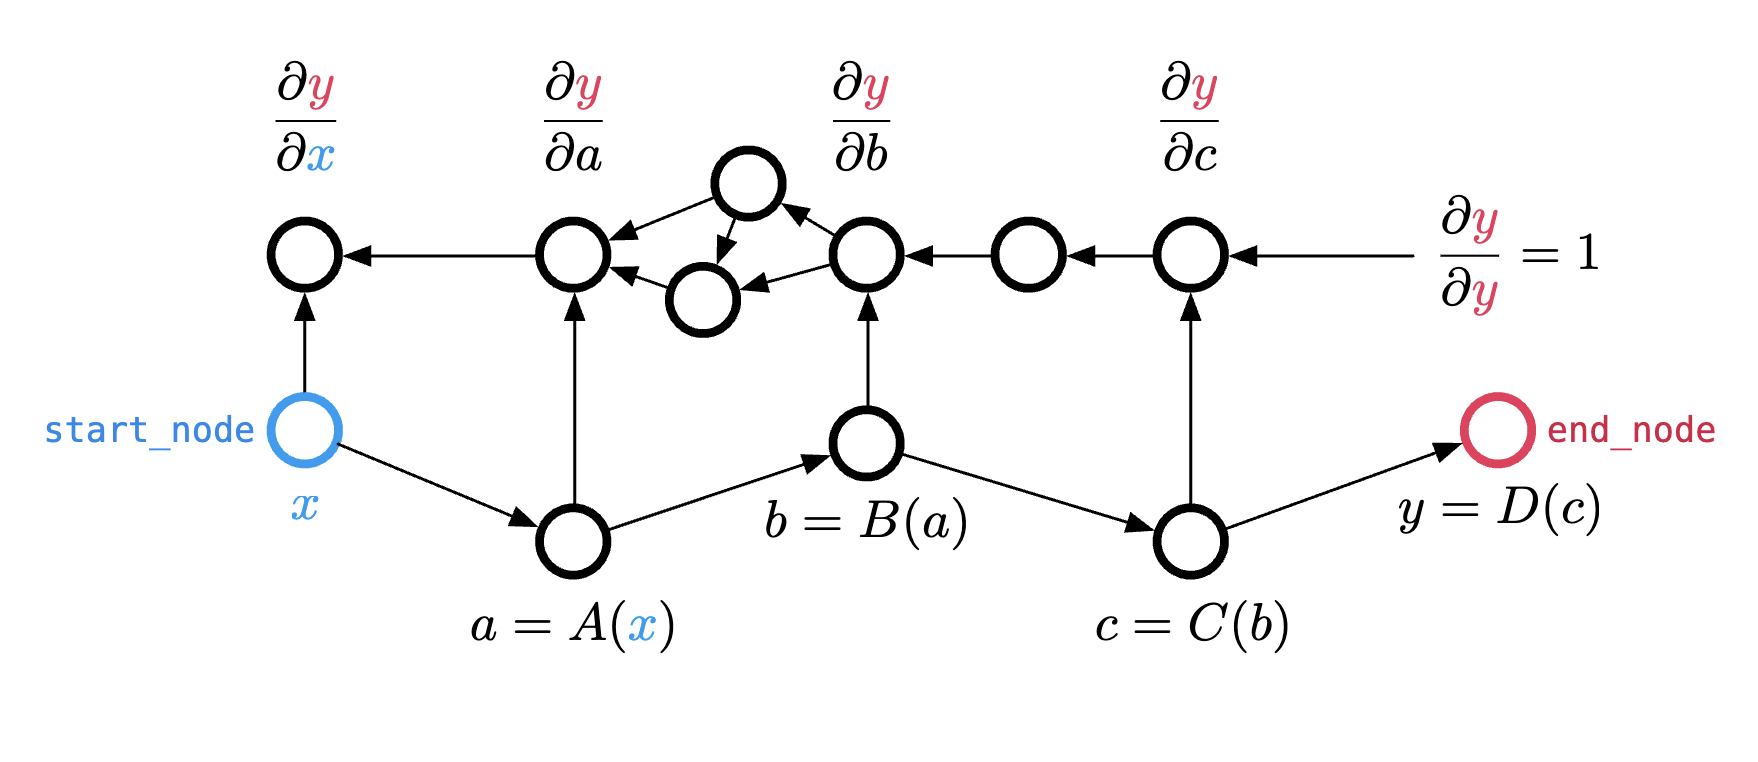
</details>

In [16]:
"""Import the full definitions of np and primitive_vjps"""
from microjax import np, primitive_vjps

We previously defined the forward pass in `trace`. Now we have the graph and need to do the backward pass along the graph. This composes all of the primitive VJPs together to make a composite VJP for the entire function.

Finally, to get the gradient, we just call this VJP with the $\frac{\partial{y}}{\partial{y}} = 1$.

In [17]:
def backward_pass(g, end_node):
    outgrads = {end_node: g}
    for node in toposort(end_node):
        outgrad = outgrads.pop(node)
        fun, value, args, kwargs, argnums = node.recipe
        for argnum, parent in zip(argnums, node.parents):
            vjp = primitive_vjps[fun][argnum]
            parent_grad = vjp(outgrad, value, *args, **kwargs)
            outgrads[parent] = add_outgrads(outgrads.get(parent), parent_grad)
    return outgrad

def make_vjp(fun, x):
    start_node = Node.new_root()
    end_value, end_node = trace(start_node, fun, x)

    # This means that the output didn't depend on the input so the gradient is 0
    if end_node is None:
        def vjp(g):
            return np.zeros_like(x)
    else:
        def vjp(g):
            return backward_pass(g, end_node)

    return vjp, end_value

def grad(fun, argnum=0):
    def gradfun(*args, **kwargs):
        # Replace args[argnum] with x. Define a single-argument function to
        # compute derivative wrt.
        def unary_fun(x):
            new_args = list(args)
            new_args[argnum] = x
            return fun(*new_args, **kwargs)

        # Construct a vector-Jacobian product for the function
        vjp, ans = make_vjp(unary_fun, args[argnum])
        return vjp(np.ones_like(ans))

    return gradfun

And that's it! `grad` is the main entrypoint so we now have a working Microjax!

### Testing

Let's see a few examples:

In [18]:
from microjax import jacobian, np
arr = np.array([1.,2.,3.])

Recall that the derivative of `exp` is `exp`:

In [19]:
(jacobian(np.exp)(arr),
 np.exp(arr))

(array([ 2.71828183,  7.3890561 , 20.08553692]),
 array([ 2.71828183,  7.3890561 , 20.08553692]))

(Note that I'm using `jacobian` rather than `grad` because I'm using vectorized functions which return an array rather than a scalar. All of these are equivalent to just taking three derivatives in parallel.)

In [20]:
(jacobian(lambda x: np.exp(x) + np.log(x))(arr),
 (lambda x: np.exp(x) + 1. / x)(arr))

(array([ 3.71828183,  7.8890561 , 20.41887026]),
 array([ 3.71828183,  7.8890561 , 20.41887026]))

Let's revisit `f` and `g` from earlier.

In [21]:
def f(x):
    import random
    return np.exp(x) if random.random() < 0.5 else np.log(x)

jacobian(f)(arr)

array([ 2.71828183,  7.3890561 , 20.08553692])

In [22]:
def g(x):
    for i in range(5):
        x = x + 1
    return x

jacobian(g)(arr)

array([1., 1., 1.])

### Summary

There were three main parts of the implementation:

1. Build a computation graph:
   `Box`, `Node`, `primitive`, and `trace`
2. Define a vector-Jacobian product (VJP) for each primitive:
   `primitive_vjps`
3. Compose VJPs backward:
   `backward_pass`, `make_vjp`, `grad`

Where to go from here? There's a very important piece that's still missing,
but I don't want to make this tutorial any longer.

Right now, we can only get the gradient for one array. So we could update, say,
the weights in one layer. But we can't update a whole model at once. For that you'd need
something like Jax's [pytrees](https://docs.jax.dev/en/latest/working-with-pytrees.html),
which tell Jax how to update a whole container, for example, a model with many layers.